In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50

import h5py

In [2]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
#in_images = tf.placeholder(tf.string)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))
#image_tensors = preprocess_numpy(in_images)

In [3]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

Using TensorFlow backend.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code E3Q39U88B to authenticate.
1.1.6-rc


In [4]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

Registering model resnet50-1.1.6-rc-model
Successfully registered model resnet50-1.1.6-rc-model
Creating service featurizer-service-08cdb9
. . . . . . . . . 
Successfully created service featurizer-service-08cdb9


In [24]:
def preprocess_oneimage(np_array):
    image = tf.cast(np_array, dtype=tf.float32)
    output_width = 224
    output_height = 224
    resize_min = 256

    image_grayscale = tf.image.grayscale_to_rgb(image)
    image_resize = tf.image.resize_images(image_grayscale, [224,224])
    #image_resize = amlrealtimeai.resnet50.utils._aspect_preserving_resize(image, resize_min)
    #image_resize = amlrealtimeai.resnet50.utils._central_crop(image, output_height, output_width)
    image_resize.set_shape([output_height, output_width, 3])
    image_resize = tf.to_float(image_resize)
    image_resize = tf.expand_dims(image_resize, 0)

    slice_red = tf.slice(image_resize, [0, 0, 0, 0], [1, 224, 224, 1])
    slice_green = tf.slice(image_resize, [0, 0, 0, 1], [1, 224, 224, 1])
    slice_blue = tf.slice(image_resize, [0, 0, 0, 2], [1, 224, 224, 1])

    sub_red = tf.subtract(slice_red, 123.68)
    sub_green = tf.subtract(slice_green, 116.779)
    sub_blue = tf.subtract(slice_blue, 103.939)
    return tf.concat([sub_blue, sub_green, sub_red], 3)
def _decode(tensor):
    return tf.squeeze(preprocess_oneimage(tensor))
def preprocess_nparray(in_images):
    #tf.convert_to_tensor(in_images)
    return tf.map_fn(_decode,in_images, tf.float32)

# Load MNIST
f = h5py.File("/Users/mialiu/Downloads/mnist_test.hdf5",'r')
NUMBER_OF_DATA = 5000
images = np.array(f['features'])[:NUMBER_OF_DATA]
images = images.reshape(images.shape[0], images.shape[2], images.shape[3], images.shape[1]).astype('float32')
images_tf = tf.convert_to_tensor(images)
images_preprocessed = preprocess_nparray(images_tf)
labels = np.array(f['targets'])
labels = labels.reshape(labels.shape[0])

with tf.Session() as sess:
        images_array = images_preprocessed.eval(session=sess)
f.close()


In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, images.shape[0], n):
        yield l[i:i + n]
    
# Extract features
feature_list = []
with tf.Session() as sess:
    for chunk in tqdm(chunks(images_array,100)):
        result= sess.run([features],feed_dict={image_tensors:chunk})
        feature_list.extend(result[0])

feature_results = np.array(feature_list)


0it [00:00, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/mialiu/anaconda3/envs/amlrealtimeai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/mialiu/anaconda3/envs/amlrealtimeai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/mialiu/anaconda3/envs/amlrealtimeai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

50it [06:26,  7.74s/it]

(5000, 1, 1, 2048)


In [103]:
featurizer.cleanup_remote_service()

In [17]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 10

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

onehot_labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels[:5000], random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3750, 1, 1, 2048) (1250, 1, 1, 2048) (3750, 10) (1250, 10)


In [19]:
model.fit(X_train, y_train, epochs=16, batch_size=32)

Epoch 1/16
3750/3750 [==============================] - 3s 680us/step - loss: 0.4560 - acc: 0.8170
Epoch 2/16
3750/3750 [==============================] - 2s 533us/step - loss: 0.3326 - acc: 0.8992
Epoch 3/16
3750/3750 [==============================] - 2s 526us/step - loss: 0.3186 - acc: 0.8997
Epoch 4/16
3750/3750 [==============================] - 2s 528us/step - loss: 0.3044 - acc: 0.9008
Epoch 5/16
3750/3750 [==============================] - 2s 538us/step - loss: 0.2907 - acc: 0.9020
Epoch 6/16
3750/3750 [==============================] - 2s 565us/step - loss: 0.2806 - acc: 0.9030
Epoch 7/16
3750/3750 [==============================] - 2s 578us/step - loss: 0.2705 - acc: 0.9045
Epoch 8/16
3750/3750 [==============================] - 2s 568us/step - loss: 0.2611 - acc: 0.9061
Epoch 9/16
3750/3750 [==============================] - 2s 553us/step - loss: 0.2556 - acc: 0.9075
Epoch 10/16
3750/3750 [==============================] - 2s 661us/step - loss: 0.2468 - acc: 0.9086
Epoch 11/

In [20]:
from numpy import argmax

y_probs = model.predict(X_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_probs)
print(y_prob_max)
print(y_test_max)

[[0.16075492 0.03444348 0.09481604 ... 0.03008311 0.1324245  0.29789135]
 [0.02534615 0.00490385 0.15945785 ... 0.07400102 0.08959952 0.07787781]
 [0.01459032 0.00471257 0.1430545  ... 0.06910839 0.03221072 0.0487008 ]
 ...
 [0.12292039 0.19669485 0.15222585 ... 0.04283774 0.08361918 0.3038162 ]
 [0.01508293 0.07729933 0.11828277 ... 0.4071756  0.03243372 0.08677053]
 [0.02695207 0.0110796  0.19062136 ... 0.04440204 0.02207025 0.0583211 ]]
[9 3 3 ... 9 7 2]
[9 5 5 ... 9 7 2]


Accuracy 0.736
Precision [0.85964912 0.93706294 0.48701299 0.53266332 0.7875     0.5625
 0.86407767 0.77570093 0.7739726  0.80555556]
Recall [0.94230769 0.97101449 0.67567568 0.94642857 0.86896552 0.06569343
 0.7007874  0.63358779 0.91129032 0.71900826]
F1 [0.89908257 0.95373665 0.56603774 0.68167203 0.82622951 0.11764706
 0.77391304 0.69747899 0.83703704 0.75982533]
Confusion Matrix [[98, 0, 2, 0, 0, 0, 1, 0, 3, 0], [0, 134, 0, 0, 2, 0, 0, 2, 0, 0], [0, 2, 75, 8, 5, 0, 4, 5, 8, 4], [0, 0, 2, 106, 0, 1, 1, 0, 2, 0], [0, 1, 3, 0, 126, 0, 0, 14, 0, 1], [2, 0, 39, 81, 0, 9, 2, 2, 1, 1], [11, 1, 10, 1, 1, 0, 89, 0, 5, 9], [0, 5, 14, 1, 21, 1, 1, 83, 0, 5], [0, 0, 3, 1, 2, 2, 2, 0, 113, 1], [3, 0, 6, 1, 3, 3, 3, 1, 14, 87]]


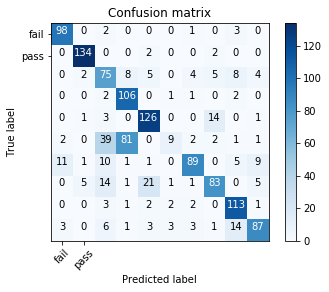

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=False)